# Reinforcement Learning: Q-Learning
## Mohammad Ali Zamani
### Senior Machine Learning Scientist
 [zamani.ai](https://zamani.ai)


---



In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install imageio==2.4.1 > /dev/null 2>&1
!pip install -U colabgymrender > /dev/null 2>&1
!pip install gym[classic_control] > /dev/null 2>&1

In [2]:
# the env description: https://github.com/openai/gym/wiki/MountainCar-v0
# random action solution
import gym
from colabgymrender.recorder import Recorder

env_with_recorder = gym.make("MountainCar-v0")
directory = './video'
env_with_recorder = Recorder(env_with_recorder, directory)

# car starts from a random position
observation = env_with_recorder.reset()

# until we have not done with the goal (i.e. reaching terminal state)
done = False
while not done:

    # select a random action
    action = env_with_recorder.action_space.sample()

    # execute the action and see the observation
    observation, reward, done, info = env_with_recorder.step(action)

env_with_recorder.play()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3563520/45929032 bytes (7.8%)7233536/45929032 bytes (15.7%)9633792/45929032 bytes (21.0%)13058048/45929032 bytes (28.4%)16441344/45929032 bytes (35.8%)20291584/45929032 bytes (44.2%)23863296/45929032 bytes (52.0%)27295744/45929032 bytes (59.4%)30031872/45929032 bytes (65.4%)32604160/45929032 bytes (71.0%)34873344/45929032 bytes (75.9%)37150720/45929032 bytes (80.9%)

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  result = np.fromstring(s, dtype='uint8')



In [3]:
# since we work with discrete rl we need a descretizer
class Discretizer():
    def __init__(self, env, s1_disc_num=10, s2_disc_num=100):
        
        self.s1_disc_num = s1_disc_num
        self.s2_disc_num = s2_disc_num
        self.action_space_num = env.action_space.n
        self.obs_low_bound = env.observation_space.low

        self.x_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=s1_disc_num)
        self.v_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=s2_disc_num)
        self.num_states = np.array([len(self.x_bins), len(self.v_bins)])
        print(self.num_states)

    
    def init_Q(self):
        # Initialize Q table
        return np.random.uniform(low = -1, high = 1, 
                          size = (self.num_states[0], self.num_states[1], 
                                  self.action_space_num))
        
    def init_V(self):
        return np.random.uniform(low = -1, high = 1, 
                          size = (self.num_states[0], self.num_states[1]))
        
    def descritize(self, observation):
        # Discretize state
        return np.array([np.digitize(observation[0], self.x_bins)-1, np.digitize(observation[1], self.v_bins)-1])



[40 40]
Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -199.73
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -199.66
Episode 1600 Average Reward: -199.31
Episode 1700 Average Reward: -198.91
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -197.9
Episode 2000 Average Reward: -195.0
Episode 2100 Average Reward: -196.82
Episode 2200 Average Reward: -198.01
Episode 2300 Average Reward: -198.0
Episode 2400 Average Reward: -198.23
Episode 2500 Average Reward: -194.81
Episode 2600 Average Reward: -198.54
Episode 2700 Average Reward: -198.86
Episode 2800 Averag

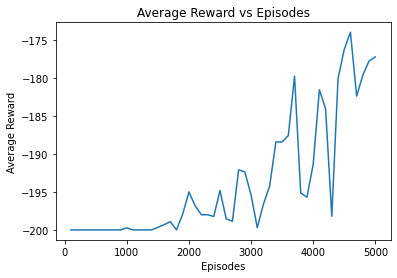

In [4]:
# https://gist.github.com/gkhayes/3d154e0505e31d6367be22ed3da2e955
import numpy as np
import gym
import matplotlib.pyplot as plt
import time

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()

# Define Q-learning function
def QLearning(env, lr, discount, epsilon, min_eps, episodes,
              s1_disc_num=10, s2_disc_num=100, discretizer=None):
    
    # Initialize Q table
    Q = discretizer.init_Q()
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes

    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        curr_state = discretizer.descritize(state)
    
        while done != True:   

            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[curr_state[0], curr_state[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            next_observation, reward, done, info = env.step(action) 
            
            # Discretize state2
            next_state = discretizer.descritize(next_observation)
            
            #Allow for terminal states
            if done:
                Q[curr_state[0], curr_state[1], action] = reward
            
            # Adjust Q value for current state
            else:
                delta = lr * (reward + discount * np.max(Q[next_state[0], next_state[1]]) - Q[curr_state[0], curr_state[1], action])
                Q[curr_state[0], curr_state[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            curr_state = next_state
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    
    return ave_reward_list, Q, discretizer
# number of grids for s1 (pos) and s2 (vel)
s1_disc_num=40
s2_disc_num=40

# construct the discretizer
discretizer = Discretizer(env, s1_disc_num, s2_disc_num)

# Run Q leanring
rewards, Q, discretizer = QLearning(env,
                                    lr=0.2,
                                    discount = 0.999,
                                    epsilon=0.4,
                                    min_eps=0.05,
                                    episodes=5000,
                                    s1_disc_num=s1_disc_num,
                                    s2_disc_num=s2_disc_num,
                                    discretizer=discretizer)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()

# Save the final Q
with open('./Q.npy', 'wb') as f:
    np.save(f, Q)


In [5]:
import gym
from colabgymrender.recorder import Recorder
import numpy as np
env = gym.make("MountainCar-v0")

directory = './video'
env = Recorder(env, directory)

# if session crashed uncomment the following lines to load from the saved Q
# s1_disc_num=40
# s2_disc_num=40
# discretizer = Discretizer(env, s1_disc_num, s2_disc_num)
# Q = np.load('./Q.npy',allow_pickle=True)

# reset the evn
observation = env.reset()

# until the car has not reached the terminal state
done = False
while not done:
    # find the descrete state
    state = discretizer.descritize(observation)

    #find the best action
    action = np.argmax(Q[state[0], state[1]]) 
    
    # execute the action
    observation, reward, done, info = env.step(action)

env.play()

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  result = np.fromstring(s, dtype='uint8')

  warnings.warn("Warning: in file %s, "%(self.filename)+

